## Creating Drug-Gene embeddings for exploratory bioinformatics

In this notebook, knowledge graphs and their respective ontologies are used to create embeddings for drug-gene interactions (for genes occuring in humans). The strategy is as follows:
1. ChG-Miner dataset from Stanford is downloaded (correction - using drugbank because it's much richer)
2. The ontologies that contains more info for the genes and drugs is downloaded
3. Random embeddings are created that correspond to each drug and gene/gene group
4. A graph for the drug-gene interactions is built
5. A self-supervised technique to update gene/drug representations is applied.


## Knowledge graph refs for drug repurposing

|Date|Title|Link|Approach/notes|
|---|---|---|---|
| 08-01-2019  | Discovering protein drug targets using knowledge graph embeddings | [link](https://aran.library.nuigalway.ie/bitstream/handle/10379/15375/main_dti.pdf;jsessionid=DED09659DD7154C06E2E6DFE73C18213?sequence=1)| Link prediction in knowledge graphs|
| 2023-ICLR | Protein representation learning bia knowledge-enhanced primary structure modeling| [link](https://www.biorxiv.org/content/10.1101/2023.01.26.525795v1.full.pdf) | Masked language model for aminoacids, language embs |
|2022-ICLR |OntoProtein: Protein pretraining with gene ontology embedding | [link](https://arxiv.org/pdf/2201.11147.pdf)|Masked language models + gene ontology knowledge graph use|
|31-01-2022| A knowledge graph to interpret clinical proteomics data |[link](https://www.nature.com/articles/s41587-021-01145-6) | Clinical knowledge graph - no ML. "Clinical proteomics" - may be used to extend the work to clinical/disease data.|
|2020-Nature|Preclinical validation of therapeutic targets predicted by tensor factorization on heterogeneous graphs | [link](https://www.nature.com/articles/s41598-020-74922-z.epdf?sharing_token=9g5nJI1kxkoZN02KQ4PqcdRgN0jAjWel9jnR3ZoTv0P9D9RrU4AAqO3Z-w2ZIYdnJNBD_lL2uovY6Q_qmY4OEC6tB3uqFlmfju-HLeKNbAJDGoiN7Sg8gxqWwy2vJwCXe4YkeXIVeHu2k1B1Som41XusV8f8JV_ygMXNEBbkYgk%3D) | BenevolentAI work | 
|2022-Nature| Affinity2Vec: drug-target binding affinity prediction through representation learning, graph mining, and machine learning |[link](https://www.nature.com/articles/s41598-022-08787-9) | References a lot of interesting work on the topic of Drug-Target-Binding Affinity (DTBA) problem. Useful for extensions that contain more refined edge features. |
|2022-PMLR| Graph-Text Multi-Modal Pre-training for Medical Representation Learning  | [link](https://proceedings.mlr.press/v174/park22a/park22a.pdf)| Cross-modal contrastive pre-training with focus on EHR last author is E. Choi (author of GRAM)|

## Useful models/resources
|Model|Link|Description|
|---|---|---|
|OntoProtein | [HuggingFace link](https://huggingface.co/zjunlp/OntoProtein) | The OntoProtein model (see papers above) |
|Colab for ProtT5| [notebook link](https://colab.research.google.com/drive/1TUj-ayG3WO52n5N50S7KH9vtt6zRkdmj?usp=sharing#scrollTo=6OC1toF1EM9n)| A ProtT5 model in high-precission (so it can be run in google colab)|
|CLUE: The drug repurposing hub (case studies)| [link](https://clue.io/repurposing#case-studies) | Check out for inspiration on what to do with the trained model (and how to define training objectives)|
|A Deep Learning Approach to Antibiotic Discovery|[link](https://www.cell.com/cell/fulltext/S0092-8674(20)30102-1)| The high-profile success story of Halicin case (often cited as a success of GNNs).|
|NA| [Youtube link](https://www.youtube.com/watch?v=0iaeD0BSByw) | Recent video (March '23) from Avi Ma'ayan on his lab's work related to bioinformatics KGs. Relevant for extensions to phenotype data, or in general linking to other KGs. |
|ΝΑ|[github link](https://github.com/benb111/awesome-small-molecule-ml#papers-adme-tox)| "Awesome" list with small mollecule deep learning works.|


## Progress
### Preparation/Pre-processing
* Cleaned DrugBank KG (in retrospect there are other KGs that are freely available for reproducibility)
* Computed protein embeddings with a half-precission version of ProtT5 
* Filtered targets/drugs/relations that do not have enough data (left with some 1000s of nodes for drugs and targets and 11 different types of "relations" (with `other` being the most common...).
* Wrote GraphSage-type graph samplers that are compatible with `tf_gnns` (my library).
* Adapted the `tf_gnns` library to easilly create MPNNs with no global features and wrote tests for the new implementation (may help with cleaner and more efficient)

### Training
TODO

### Validation
TODO

### Ideas
* Use mollecular properties and/or BioBERT embeddings (in addition to the graph embeddings) for learning the representations



In [1]:
#@title Installs (`ProtT5` needs `transformers` and `SentencePiece`)
INSTALL_TRANSFORMERS = True #@param {'type' : 'boolean'}
if INSTALL_TRANSFORMERS:
    !pip install SentencePiece
    !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00


In [2]:
!pip install tf_gnns==0.1.5a2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title `ProtT5` model (not essential - can use pre-computed embeddings)
from transformers import T5EncoderModel, T5Tokenizer
import torch
class ProtT5EmbModel:
    def __init__(
        self, 
        model_string : str= "Rostlab/prot_t5_xl_half_uniref50-enc", 
        device : str= 'cuda:0'):
        """
        ProtT5EmbModel:

        a quick and dirty inference for ProtT5 model. The max sequence computable 
        with colab is ~4.5k aminoacids.

        """
        self.model_string = model_string
        self.device = device
        self._get_model()
        self.model, self.tokenizer = self._get_model()

    def _get_model(self):
        model = T5EncoderModel.from_pretrained(self.model_string)
        model = model.to(device) # move model to GPU
        model = model.eval() # set model to evaluation mode
        tokenizer = T5Tokenizer.from_pretrained(self.model_string, do_lower_case=False)
        return model, tokenizer

    def _compute_on_targets(self,targets_and_sequences : dict):
        """
        Given a dictionary of target:sequence (in fasta format) compute the
        embeddings.
        """
        #sort to maybe enable batching (not extremely helpful - the problem is
        #  the larger sequences)

        self.seq_dict = sorted( targets_and_sequences.items(), key=lambda kv: len( targets_and_sequences[kv[0]] ), reverse=True )

    def _comp(
        self,
        inds_to_compute
        ):
        
        try:
            seqs = [' '.join(self.seq_dict[i][1]) for i in inds_to_compute]
            token_encoding = self.tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
            with torch.no_grad():
                # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
                emb_repr = self.model(input_ids, attention_mask=attention_mask)
            return emb_repr['last_hidden_state'].mean(-2).detach().cpu().numpy()
        except:
            print("RuntimeError during embedding")
    
    def _comp_all(
        self,
        file_to_save_at = 'protein_embeddings_file.pd',
        max_seq_len = 4563,
        save_every = 100
        ):
        """
        Computing with single example in batch (~40mins for ~4k proteins with max length 4k aminoacids)
        """
        results = {}
        # manually selected - memory limmitations do not allow very large proteins.
        start_idx = 10 
        for sd in tqdm(range(0, len(self.seq_dict))):
            if len(self.seq_dict[sd][1]) > max_seq_len:
                print('target {} larger than max_seq_len ({}). Did not compute.'.format(self.seq_dict[sd][0],len(self.seq_dict[sd][1])))
                continue
            res = self._comp([sd])
            results[self.seq_dict[sd][0]] = [res[0].astype('float16')]
            if (sd+1) % save_every == 0:
                pd.DataFrame(results).T.to_pickle(os.path.join(data_root_folder,file_to_save_at))
                print('saving to' + os.path.join(data_root_folder,file_to_save_at))

        pd.DataFrame(results).T.to_pickle(os.path.join(data_root_folder,file_to_save_at))

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as pplot

import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#@title Where to save or load from the datasets

import os
# !mkdir /content/gdrive/MyDrive/datasets
# !mkdir /content/gdrive/MyDrive/datasets/DrugDiscovery
data_root_folder = '/content/gdrive/MyDrive/datasets/DrugDiscovery' #@param {type : 'string'}
os.environ['DATA_ROOT_FOLDER'] = data_root_folder
DOWNLOAD_DATA = False #@param {type : 'boolean'}
PREP_DATA = False #@param {type : 'boolean'}
CREATE_SUBGRAPH = False #@param {type : 'boolean'}
PROT_EMB_PATH = os.path.join(data_root_folder,'protein')
PROT_EMB_PATH_HalfPrec = os.path.join(data_root_folder, 'computed_protT5_uniprot_half_precission.pd')

In [10]:
#@title Downloading and preparation of data (if neccessary)
if DOWNLOAD_DATA:
    # For drug-gene interactions
    !wget --directory-prefix=$DATA_ROOT_FOLDER https://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz

    # for gene naming
    !wget --directory-prefix=$DATA_ROOT_FOLDER https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/hgnc_complete_set.json

    # drug ontology (not drugbank! - the drug-disease interaction graph is using drugbank IDs!)
    # !wget https://kg-hub.berkeleybop.io/kg-obo/dron/2022-04-22/dron.json

    # see https://www.uniprot.org/help/downloads#embeddings
    # and https://www.uniprot.org/help/embeddings for source of the embeddings. 
    # This is a "pre-alphafold1" transformer repr. learning technique for aminoacids 
    # using the "ProtT5" model.
    !wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5
    !mkdir $DATA_ROOT_FOLDER/prot-embedings/ && mv per-protein.h5 $DATA_ROOT_FOLDER/prot-embedings/per-protein.h5

if PREP_DATA:
    !mkdir drugbank_data && mkdir drugbank_data/drug_data %mkdir drugbank_data/target_data
    !cd drugbank_data/drug_data && unzip $DATA_ROOT_FOLDER/drugbank_all_full_database.xml.zip 
    !cd drugbank_data/target_data && unzip $DATA_ROOT_FOLDER/drugbank_all_target_polypeptide_ids.csv.zip
    !cp -r $DATA_ROOT_FOLDER/prot-embedings.h5 . 

df_drug_gene = pd.read_csv(os.path.join(data_root_folder,'ChG-Miner_miner-chem-gene.tsv.gz'), compression='gzip', header=0, sep='\t')
# target_ids = pd.read_csv('drugbank_data/target_data/all.csv')

SUBGRAPH_PATH = os.path.join(data_root_folder,'drugbank_subgraph')


# If subgraph is not created it is loaded from disk.
if CREATE_SUBGRAPH:

    def _get_drug_drug(adv_eff_elm):
        d = {}
        for i in adv_eff_elm:
            d[_strip_tag_text(i.tag)] = i.text
        return d

    def _proc_child(child, drugs_to_keep = []):
        # to get drug-drug interactions of for a drug:
        db_id = [d.text for d in _findall(child, 'drugbank-id') if 'DB' in d.text]
        # db_id = db_id[0]
        _id = None
        for _db_id in db_id:
            if _db_id in drugs_to_keep:
                _id = _db_id
                break

        if _id is None:
            return None

        d = {'drugbank-id' : _id}
        for c in _findall(child, 'drug-interactions'):
            all_inters = [];
            for cc in c:
                all_inters.append(_get_drug_drug(cc))
        d['drug-interactions'] = all_inters
        d['description'] = _find(child, 'description').text

        return d

    tree = ET.parse('drugbank_data/drug_data/full database.xml')
    root = tree.getroot()

    keep_list = set(df_drug_gene['#Drug'].unique())
    subgraph_drug_data = []
    for child in root:
        res = _proc_child(child, drugs_to_keep = keep_list)
        if res is not None:
            subgraph_drug_data.append(res)
            
    subgraph_drug_data_df = pd.DataFrame(subgraph_drug_data)
    subgraph_drug_data_df.to_csv(SUBGRAPH_PATH)
    # del tree
else:
    subgraph_drug_data_df = pd.read_csv(SUBGRAPH_PATH)
    

In [11]:
#@title Pre-proc DrugDank data to get subgraph (also pre-computed). If `False`, reads from disc.
DRUGBANK_GRAPH_DATA_PROC = False #@param {'type' : 'boolean'}
SUBGRAPH_FILE_NAME = 'drugbank_subgraph_v3' #@param ['drugbank_subgraph_v2', 'drugbank_subgraph_v3']
def _strip_tag_text(v):
    return v[24:]

def _find(cc,tag):
    return cc.find('{http://www.drugbank.ca}' + tag)

def _findall(cc,tag):
    return cc.findall('{http://www.drugbank.ca}' + tag)

# SUBGRAPH_PATH_v2 = os.path.join(data_root_folder,'drugbank_subgraph_v2')
SUBGRAPH_PATH = os.path.join(data_root_folder,'drugbank_subgraph_v3')
if DRUGBANK_GRAPH_DATA_PROC:
    def _get_actions(actions_element):
        r = []
        for a in actions_element:
            r.append({_strip_tag_text(a.tag) :  a.text})
        return r

    def _get_polypeptide(polypeptide_element):
        keep_tags = ['name','general-function','amino-acid-sequence']
        dat = {}
        dat.update({polypeptide_element.items()[0][0] : polypeptide_element.items()[0][1]})
        for p in polypeptide_element:
            tt = _strip_tag_text(p.tag)
            if tt in keep_tags:
                dat[tt] = p.text
        return dat
        
    def _get_target(target_element):
        scrape_strategies = {'actions' : _get_actions ,'polypeptide' : _get_polypeptide}
        dtarg = []
        for p in target_element:
            
            dtarg_d = {}
            for pp in p:
                tt = _strip_tag_text(pp.tag)
                if tt in scrape_strategies:
                    dtarg_d[tt] = scrape_strategies[tt](pp)
            dtarg.append(dtarg_d)
        return dtarg

    def _proc_drug_elm(d):
        dd = {}
        for d_ in d:
            dd[_strip_tag_text(d_.tag)] = d_.text
        return dd

    def _proc_iter(cc,tag):
        tt = '{http://www.drugbank.ca}' + tag
        res = {}
        for c in cc:
            if tag == 'enzymes':
                if tag not in res:
                    res[tag] = [c.text]
                else:                
                    res[tag].append(c.text)
            if tag == 'drugs':
                if tag in res:
                    res[tag].append(_proc_drug_elm(c))
                else:
                    res[tag] = [_proc_drug_elm(c)]
        return res


    def _get_pathways_element(pathways_elm):
        pathways = []
        all_pw_dat = {}
        for p in pathways_elm:
            keep_tags = ['category','name','smpdb-id']
            for p_ in p:
                tt = _strip_tag_text(p_.tag)
                if tt in ['drugs', 'enzymes']:
                    res = _proc_iter(p_, tt)
                    all_pw_dat.update(res)

                if tt in keep_tags:
                    all_pw_dat[tt] = p_.text
            pathways.append(all_pw_dat)
            all_pw_dat = {}
        return pathways

    def _small_mol(c):
        """
        to parse the small molecule data
        """
        tags_to_keep_text = ['drugbank-id','name','description','indication','mechanism-of-action']
        res_dict = {}
        for c_ in c:
            tt = _strip_tag_text(c_.tag)
            if tt in tags_to_keep_text:
                res_dict[tt] = c_.text
            if tt == 'pathways':
                res_dict[tt] = _get_pathways_element(c_)
            if tt == 'targets':
                res_dict[tt] = _get_target(c_)
        return res_dict

    def _biotech(c):
        """
        to parse the biotech data
        """
        return _small_mol(c)

    drug_centric = []
    for c in root:
        if c.items()[0][1] == 'small molecule':
            p = _small_mol(c)
        if c.items()[0][1] == 'biotech':
            p  = _biotech(c)
        drug_centric.append(p)
    dbdata = pd.DataFrame(drug_centric)
    dbdata.to_pickle(SUBGRAPH_PATH)
else:
    dbdata = pd.read_pickle(SUBGRAPH_PATH)

  0%|          | 0/15235 [00:00<?, ?it/s]

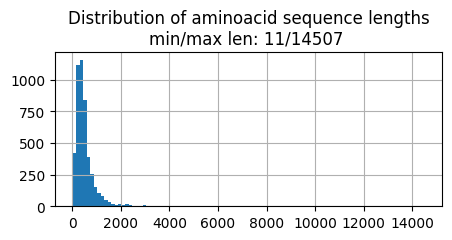

In [12]:
#@title Visualization of polypeptide sizes (colab GPU can handle up to 4.5k residues)
## Compute all targets and sequences
from tqdm.auto import tqdm

def _replace_nonstandard(s):
    """
    From the ProtT5 code (see "useful resources" in the top) check - read_fasta
    """
    return s.replace('U','X').replace('Z','X').replace('O','X')

targets_and_sequences = {}
for t in tqdm(dbdata['targets']):
    for tt in t:
        if 'polypeptide' in tt:
            ppt = tt['polypeptide']['id']

            if ppt in targets_and_sequences:
                continue
            seq = ''.join(tt['polypeptide']['amino-acid-sequence'].split('\n')[1:])
            seq = _replace_nonstandard(seq)
            targets_and_sequences[ppt] = seq     

targ_len = [len(ss) for tt, ss in targets_and_sequences.items()]
p = pplot.figure(figsize = (5,2), dpi = 100)
p = pplot.hist(targ_len, 100)
max_seq, min_seq = max(targ_len), min(targ_len)
pplot.title('Distribution of aminoacid sequence lengths\nmin/max len: %i/%i '%(min_seq, max_seq))
pplot.grid()
pplot.show()

In [13]:
computed_prot_emb = pd.read_pickle(PROT_EMB_PATH_HalfPrec)
target_emb_dict = {k : v for k, v in computed_prot_emb.reset_index().values}

In [14]:
computed_prot_emb

,0
P04114,"[0.0413, -0.1171, -0.01254, 0.03058, -0.01344,..."
P08519,"[0.1737, 0.1521, -0.01371, 0.1003, 0.0992, 0.0..."
Q07954,"[0.02309, 0.05316, 0.0623, 0.04175, -0.02142, ..."
P0DTC1,"[0.01039, -0.05624, 0.001566, 0.0801, 0.00258,..."
P98160,"[0.003035, 0.0462, 0.0515, 0.000439, -0.00786,..."
...,...
P0C1V1,"[0.012314, -0.08545, 0.09296, 0.003925, 0.0337..."
Q16498,"[0.0614, 0.0352, -0.04218, -0.0548, 0.0627, 0...."
O43519,"[0.10394, 0.02731, -0.09735, -0.01855, 0.00053..."
P0C2S2,"[0.147, 0.0628, -0.08606, -0.10345, -0.001795,..."


In [15]:
# remove the targets that have no embeddings:
no_emb_targets = set(targets_and_sequences.keys()) - set(target_emb_dict.keys())
for t in no_emb_targets:
    print(t, len(targets_and_sequences[t]))


P0C6X7 7073
Q02817 5179
P0DTD1 7096
Q98VG9 6709
K9N7C7 7078
P21817 5038
Q5T4S7 5183
Q8WXI7 14507
P98164 4655
Q92736 4967


## Data cleaning
* Removing entries that do not contain "targets"
* removing experimentals, bio-factors and others ("`AP?`") that seem to have limmited graph data
* cleaning-up some of the relations (some of them have very few occurences)
* remove some targets 
  * rare targets
  * targets for which I cannot compute embeddings for using the available models (more than 4.5k residues)
  * it is possible to associate them with other targets - e.g., with pathway data or with sequence alignment, but at this stage  I'll neglect that



In [16]:
def _clean_action_data(a):
    """
    Some combined actions are rare or have slightly different
    naming (e.g., binding/binder). This is used to consolidate them
    """
    if a == 'binder':
        return 'binding'
    if a in ['inhibition of synthesis','blocker']:
        # not the same, but could may be close:
        return 'inhibitor'
    if a == 'other/unknown':
        return 'other'
    return a

def _action_data_multi_clean(a):
    if 'downregulator' in a:
        return ['downregulator']
    if 'inhibitor' in a:
        return ['inhibitor']

    if 'antagonist' in a and 'binding' in a:
        return ['antagonist']

    if 'agonist' in a and 'binding' in a:
        return ['agonist']

    if 'antagonist' in a and 'agonist' in a:
        return ['agonist-antagonist'] # https://en.wikipedia.org/wiki/Agonist-antagonist

    if 'antagonist' in a and 'regulator' in a:
        return ['antagonist']

    if 'inhibitor' in a and 'antibody' in a:
        return ['inhibitor']
    if 'modulator' in a :
        return ['modulator']
    return a
    
    
def _get_interacting_proteins(x):
    res = []
    for e in x:
        if len(e['actions']) > 0:
            action_dat = []
            for ee in e['actions']:
                action_dat.append(_clean_action_data(ee['action']))
            action_dat = _action_data_multi_clean(action_dat)
        else:
            action_dat = ['other']
        if 'polypeptide' in e:
            res.append((action_dat[0], e['polypeptide']['id'], ))
        
    return res

def _keep_drug_id(x):
    return x[0:2] != 'BI' and x[0:2] != 'AP' and x[0:2] != 'EX' and 'SALT' not in x

def _keep_target_ids(x):
    """
    Filter out the targets for which I cannot compute embeddings due to computational 
    limmitations
    """
    
    tt = []
    for t in x:
        if 'polypeptide' in t:
            if t['polypeptide']['id'] in no_emb_targets:
                continue
            else:
                tt.append(t)    
    return tt
filtered_target_idx = dbdata.targets.apply(_keep_target_ids)
# filtered_target_idx = dbdata.targets
dbdata_f = dbdata[filtered_target_idx.apply(lambda x : len(x) > 0)] 
dbdata_f = dbdata_f[dbdata_f['drugbank-id'].apply(_keep_drug_id)]
# target_actions = dbdata_f['targets'].apply(lambda x : '.'.join([a['action'] for a in x[0]['actions']]))
# dbdata_f['target_actions'] = target_actions
targets = dbdata_f['targets'].apply(_get_interacting_proteins) # protein-to-drug
drugs = dbdata_f['drugbank-id'] # drug-to-protein
pathways = dbdata_f['pathways'] # currently unused

In [17]:
dbdata_f

,drugbank-id,name,description,indication,mechanism-of-action,pathways,targets
5,DB02351,Bivalirudin,Bivalirudin is a synthetic 20 residue peptide ...,For treatment of heparin-induced thrombocytope...,Inhibits the action of thrombin by binding bot...,"[{'smpdb-id': 'SMP0000277', 'name': 'Bivalirud...","[{'actions': [{'action': 'inhibitor'}], 'polyp..."
10,DB00084,Interferon alfa-n1,"Interferon alfa-n1 consists of purified, natur...",For the treatment of venereal or genital warts...,Interferon alpha binds to type I interferon re...,[],"[{'actions': [{'action': 'agonist'}], 'polypep..."
15,DB08923,Erythropoietin,Erythropoietin (EPO) is a growth factor produc...,Indicated in adult and paediatric patients for...,Erythropoietin or exogenous epoetin alfa binds...,[],"[{'actions': [{'action': 'agonist'}], 'polypep..."
28,DB08914,Insulin human,"Human Insulin, also known as Regular Insulin, ...",Human insulin is indicated to improve glycemic...,The primary activity of insulin is the regulat...,[],"[{'actions': [{'action': 'agonist'}], 'polypep..."
32,DB00037,Interferon alfa-2a,Interferon a (human leukocyte protein moiety r...,"For the treatment of chronic hepatitis C, hair...",Interferon alpha binds to type I interferon re...,[],"[{'actions': [], 'polypeptide': {'id': 'P17181..."
...,...,...,...,...,...,...,...
14748,DB16900,Betibeglogene autotemcel,Betibeglogene autotemcel is an autologous gene...,Betibeglogene autotemcel is indicated for the ...,Betibeglogene autotemcel is an autologous gene...,[],"[{'actions': [{'action': 'binder'}], 'polypept..."
14928,DB17080,KW-6356,KW-6356 is a selective antagonist of adenosine...,None,None,[],"[{'actions': [{'action': 'antagonist'}], 'poly..."
14931,DB17083,Linzagolix,"Linzagolix is a non-peptide, selective antagon...",Linzagolix is indicated for the treatment of m...,Linzagolix is a selective antagonist of the go...,[],"[{'actions': [{'action': 'antagonist'}], 'poly..."
14935,DB17087,JNJ-17216498,JNJ-17216498 is a histamine receptor H3 antago...,None,None,[],"[{'actions': [{'action': 'antagonist'}], 'poly..."


In [18]:
relations_count = {}
protein_targets_count = {}

for t in targets.values:
    for rel, targ in t:
        # rel= '.'.join(rel)
        if rel not in relations_count:
            relations_count[rel] = 1
        else:
            relations_count[rel] += 1

        if targ not in protein_targets_count:
            protein_targets_count[targ] = 1
        else:
            protein_targets_count[targ] += 1

In [14]:
data= np.vstack([v for v in target_emb_dict.values()])
from sklearn.manifold import TSNE
res = TSNE().fit_transform(data)

Text(0.5, 1.0, 'Protein emb. TSNE')

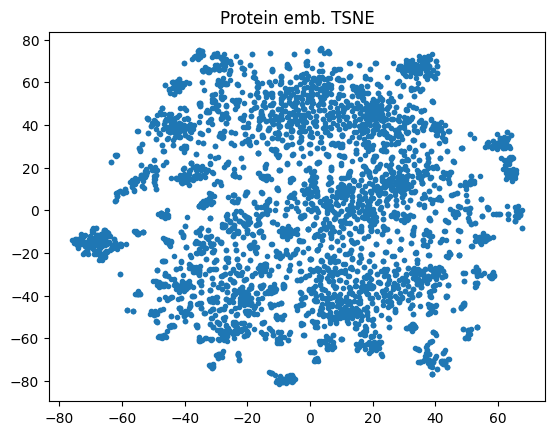

In [15]:
import matplotlib.pyplot as pplot
pplot.plot(res[:,0],res[:,1],'.')
pplot.title("Protein emb. TSNE")

In [19]:
#@title further cleaning to filter-out drugs and targets with too few relations and relations that take part in too few interactions
THRESH_KEEP_TARGET = 1  #@param {'type' : 'integer'}
THRESH_KEEP_RELATION = 30 #@param {'type' : 'integer'} rare relations set to "other"

all_relations = sorted([(k,v) for k,v in relations_count.items()], key = lambda x: x[1], reverse = 1)
relations_to_keep = [k for k, v in relations_count.items() if v > THRESH_KEEP_RELATION]
targets_filtered = {k : v for k, v in protein_targets_count.items() if v >= THRESH_KEEP_TARGET}

def _filter_relations_and_targets(targets):
    res = []
    for relation, target in targets:
        if relation not in relations_to_keep:
            relation = 'other'
        if target not in targets_filtered:
            continue
        res.append((relation, target))
    return res

targf_2 = targets.apply(_filter_relations_and_targets)
filt_idx = targf_2.apply(lambda x : len(x) > 1)
filtered_targets = targf_2[filt_idx]
filtered_drugs = drugs[filt_idx]
filtered_drugs = filtered_drugs.apply(lambda x : x.replace('SALT',''))

In [20]:
relations_list = filtered_targets.values
drugs_list = filtered_drugs.values
proteins, relations = [] , []
for rels in relations_list:
    for r in rels:
        relation, protein = r
        proteins.append(protein)
        relations.append(relation)
proteins = np.unique(proteins)
relations = np.unique(relations)

target_to_drug = {}
for r,drug in zip(filtered_targets, filtered_drugs):
    for rel_, targ_ in r:
        if targ_ in target_to_drug:
            target_to_drug[targ_].append( (drug, rel_) )
        else:
            target_to_drug[targ_] = [(drug, rel_)]

print('drugs: %i\nprotein targets: %i\ndrug-target relations: %i'%(len(filtered_drugs), len(proteins), len(relations)))

drugs: 1453
protein targets: 2616
drug-target relations: 15


In [21]:
#@title initializing the embeddings (`emb_prot`, `emb_rel`, `emb_dr`)
import numpy as np
import tensorflow as tf

EMB_SIZE = 256 #@param {type : 'integer'}
graph_entities = [proteins, relations, filtered_drugs]
np.random.seed(132)
emb_prot, emb_rel, emb_dr = \
  [tf.Variable(np.random.randn(len(n_), EMB_SIZE).astype('float32')/np.sqrt(EMB_SIZE)) for n_ in graph_entities]


dict_drug_idx = {d : i for i, d in enumerate(filtered_drugs.values)}
dict_rel_idx = {r : i for i, r in enumerate(relations)}
dict_prot_idx = {p : i  for i, p in enumerate(proteins)}

## Sampling subgraphs

The sampling procedure is as follows:
1. A set of drugs is sampled (uniformly at random)
  * A sub-set of the relations of the drugs with their targets is returned up to ``MAX_RELATIONS`` of relations.

2. From the set of targets interacting with the drugs,
   * the set of interacting drugs is retrieved
   * the drugs among the non-interacting ones are used as **hard negatives** for the drug-protein interaction task.

In [22]:
filtered_drugs

10       DB00084
28       DB08914
32       DB00037
43       DB01310
44       DB01308
          ...   
14546    DB16695
14553    DB16703
14583    DB16733
14603    DB16754
14944    DB17096
Name: drugbank-id, Length: 1453, dtype: object

In [23]:
#@title sampling graph neighborhoods (dataset index)
MAX_RELATIONS  = 3 #@param {type : 'integer'} # keeps a random number of relations
def _rel_to_emb_idx_d2t(rels):
    """
    used for drug-to-target
    """
    res = {'relations' : [], 'targets' : []}
    for r in rels:
        res['relations'].append(dict_rel_idx[r[0]])
        res['targets'].append(dict_prot_idx[r[1]])
    res['relations'], res['targets'] = np.array(res['relations']), np.array(res['targets'])
    return res

def _rel_to_emb_idx_t2d(rels):
    """
    used for target-to-drug
    """
    res = {'relations' : [], 'drugs' : []}
    for r in rels:
        res['relations'].append(dict_rel_idx[r[1]])
        res['drugs'].append(dict_drug_idx[r[0]])
    res['relations'], res['targets'] = np.array(res['relations']), np.array(res['drugs'])
    return res

def _get_relations_from_drug_list(drug_inds, max_relations = MAX_RELATIONS):
    res = []
    for d in drug_inds:
        real_rels = _rel_to_emb_idx_d2t(filtered_targets.values[d])
        if len(real_rels['relations']) > max_relations:
            r = np.random.permutation(len(real_rels['relations']))[:MAX_RELATIONS]
            real_rels['targets'], real_rels['relations'] = real_rels['targets'][r], real_rels['relations'][r]
        real_rels['drug'] = d
        res.append(real_rels)
    return res

def sample_neighborhood_of_drugs(drug_list, 
                                 max_relations = MAX_RELATIONS, 
                                 prevent_backlink = True):
    """
    1. sample the targets from the drugs (and their relation types)
    2. sample the drugs from the targets (without the original drugs)

    Objective is to make the second-level sampled drugs different from the 
    first-level sampled drugs.
    """
    # 1. sample the targets from the drugs:
    drug_links = _get_relations_from_drug_list(drug_list)

    # find the unique targets and sample the target neighborhoods:
    sub_drugs = []
    sub_targets = []
    for t in drug_links:
        sub_targets.extend(t['targets'])
        sub_drugs.append(t['drug'])
    uq_targ = np.unique(sub_targets)
    uq_drug = np.unique(sub_drugs)

    # 2. sample the drugs from the targets
    # From the proteins found in the prev. step, sample a neighborhood of drugs:
    target_links = []
    targ_proteins = proteins[uq_targ]
    for p in targ_proteins:
        t2d_rels = target_to_drug[p]
        if prevent_backlink:
            # leave-out the source "drugs"
            t2d_res = np.array([(dict_drug_idx[k[0]], dict_rel_idx[k[1]]) for k in t2d_rels if dict_drug_idx[k[0]] not in uq_drug])
        else: 
            t2d_res = np.array([(dict_drug_idx[k[0]], dict_rel_idx[k[1]]) for k in t2d_rels])

        if len(t2d_res) >= MAX_RELATIONS:
            t2d_res = t2d_res[np.random.permutation(len(t2d_res))[:MAX_RELATIONS]]
        if len(t2d_res) > 0:
            target_links.append({'target' : dict_prot_idx[p] , 'drugs' : t2d_res[:,0], 'relations' : t2d_res[:,1]})
    return drug_links, target_links



In [24]:
def _shift_shuffle_edge_list(edge_list, key):
    edge_list_copy = [{k : v for k, v in el.items() if k != key} for el in edge_list]
    shifted_key = [{**{key : k}, **el} for k, el in zip([edge_list[-1][key], *map(lambda x :x[key],edge_list[:-1])], edge_list_copy)]
    return shifted_key

drug_links, target_links = sample_neighborhood_of_drugs([10,11,12], prevent_backlink = False)
# neg_dr_links, neg_targ_links = [_shift_shuffle_edge_list(e,k) for e,k in zip([drug_links, target_links], ['drug','target'])]


In [25]:
drug_links, target_links = sample_neighborhood_of_drugs([10,20,30], prevent_backlink = False)

In [26]:
from typing import List, Dict

## Sample efficiently Graph-Tensors (GraphTuple local index)


In [27]:
# @tf.function
emb_nodes = tf.concat([emb_dr, emb_prot],0)
offs_proteins = emb_dr.shape[0]
def _graph_tuple_from_drug_subgraph(drug_links : List[Dict], 
                                    target_links : List[Dict],
                                    include_backlinks : bool = False,                                    
                                    prepare_negatives :bool = True,
                                    return_numpy : bool = True):
    """
    A helper function to gather the drug-centric and target-centric graphs.
    """
    
    
    _local_indexing_dict = {}
    def _gather_gt(edge_list : List[Dict],
                   from_key : str = 'drug',
                   to_keys  : str= 'targets', 
                   offs_nodes = 0,
                   offs_rels = 0,
                   map_from_key_idx_fn = lambda x : x ,
                   map_to_key_idx_fn = lambda x : x + offs_proteins,
                   dict_g2l = {}):
        """

        The attributed edge list of a bipartite graph can be expressed as follows:

        | from_nodes      | to_keys   | relations |
        | --------------- | ----------| --------- |
        | 0               | [2,3,4]   | [5,5,0]   |
        | 2               | [44,3]    | [23]      |
        ....
        
        the "edge_list" input represents that data in a list of dictionaries:

        [{'from_node' : 0 , 'relations' : [5,5,0] ,'to_nodes' : [2,3,4] },
         {'from_node' : 2,   'relations' : [23] , 'to_nodes' : [44,3]},
         ...]

        This function creates appropriately numbered graph tuples for attributed graphs 
        like the one in the example. 

        Arguments:
          edge_list : an edge list as a dictionary
          from_key : the key for the "from" column
          t

        
        """
        senders, receivers, node_inds, edge_inds = [[],[],[],[]]
        for d in edge_list:
            new_nodes = [map_from_key_idx_fn(d[from_key]), *map(map_to_key_idx_fn, d[to_keys])]

            _tmp_offs = offs_nodes
            local_node_inds = []
            for n in new_nodes:
                if n not in dict_g2l:
                    dict_g2l[n] = _tmp_offs
                    node_inds.append(n)
                    _tmp_offs += 1

                local_node_inds.append(dict_g2l[n])

            offs_nodes = _tmp_offs 

            # a similar procedure could be implemented to reduce the 
            # relations to their max number. However, this may be restrictive 
            # when quantitative data are used for the relations in the future 
            # (rather than the limited discrete set of "relations" currently available.)
            edge_inds.extend(d['relations'])

            s = [local_node_inds[0]] * len(d[to_keys])
            r = local_node_inds[1:]
            senders.append(s)
            receivers.append(r)
            
            if include_backlinks:
                senders.append(r)
                receivers.append(s)
                edge_inds.extend(edge_inds)

        return senders, receivers, edge_inds, node_inds, offs_nodes, offs_rels, dict_g2l

    ###############################################################################
    ## this may be traceable easilly (with inputs the edge_inds etc)
    ## Positive sampling:
    senders_d, receivers_d, edge_inds_d, node_inds, offs_nodes, offs_rels, g2l= \
        _gather_gt(drug_links,'drug','targets',0,0)
        
    nodes_d, edges_d = tf.gather(emb_nodes, node_inds), tf.gather(emb_rel, edge_inds_d)

    senders_t, receivers_t, edge_inds_t, node_inds_t, offs_nodes_t, offs_rels_t, g2l =\
       _gather_gt(target_links,'target' ,'drugs',offs_nodes, offs_rels,
            map_from_key_idx_fn = lambda x : x + offs_proteins,
            map_to_key_idx_fn = lambda x: x,
            dict_g2l = g2l)
    nodes_t, edges_t = tf.gather(emb_nodes, node_inds_t), tf.gather(emb_rel, edge_inds_t)
    
    

    all_edges = [edges_d, edges_t]
    all_nodes = [nodes_d, nodes_t]
    senders_list = [*senders_d, *senders_t]
    receivers_list = [*receivers_d, *receivers_t]
    edge_labels = tf.ones(len(edge_inds_d)+len(edge_inds_t))

    ## 
    # shufle relations (in reality just shift) 
    # and negative sampling:
    if prepare_negatives == True:
        _sdl = _shift_shuffle_edge_list(drug_links, 'drug')
        senders_nd, receivers_nd, edge_inds_nd, node_inds_nd, offs_nodes, offs_rels, g2l = \
        _gather_gt(_sdl, 'drug', 'targets', offs_nodes, offs_rels, dict_g2l = g2l)

        _sdl = _shift_shuffle_edge_list(target_links, 'target')
        senders_nt, receivers_nt, edge_inds_nt, node_inds_nt, offs_nodes, offs_rels, g2l = \
        _gather_gt(_sdl, 'target','drugs',offs_nodes, offs_rels, 
                    map_from_key_idx_fn = lambda x : x + offs_proteins,
                    map_to_key_idx_fn = lambda x: x,
                    dict_g2l = g2l)

        all_edges.append(tf.gather(emb_rel, edge_inds_nd))
        all_edges.append(tf.gather(emb_rel, edge_inds_nt))

        if len(node_inds_nd) >0: # this will not happen...
            all_nodes.append(tf.gather(emb_nodes, node_inds_nd))
            assert(0)

        if len(node_inds_nt) > 0:
            all_nodes.append(tf.gather(emb_nodes, node_inds_nt))
            assert(0)
            
        senders_list.extend([*senders_nd, *senders_nt])
        receivers_list.extend([*receivers_nd, *receivers_nt])

        edge_labels = tf.concat([edge_labels, tf.zeros(len(edge_inds_nd) + len(edge_inds_nt))],0)

    _nodes = tf.concat(all_nodes,0)
    _edges = tf.concat(all_edges,0)

    _td = {
        'nodes' : _nodes, 
        'edges' : _edges,
        'senders' : tf.concat(senders_list,0),
        'receivers'  : tf.concat(receivers_list,0),
        'n_nodes' : tf.constant([_nodes.shape[0]]),
        'n_edges' : tf.constant([_edges.shape[0]])
    }

    if return_numpy:
        ret = {}
        for k, v in _td.items():
            ret.update({k : v.numpy()})
            del v
        return ret, edge_labels

    # edge_labels = tf.concat(tf.zeros(_td['edges'].shape[0]), tf.ones(_td['edges'].shape[0]))
    return _td, edge_labels

In [28]:
# %%timeit
t1, edge_labels = _graph_tuple_from_drug_subgraph(drug_links, target_links, return_numpy = True)

# Training


In [29]:
#@title training parameters
LEARNING_RATE = 0.0001 #@param {'type' : 'number'}
EPOCHS = 30 #@param
BATCH_SIZE = 64 #@param
opt = tf.optimizers.Adam(learning_rate = LEARNING_RATE)

In [30]:
#@title Network parameters
CORE_NETWORK_SIZE = 500 #@param
NETWORK_TYPE = 'MPNN' #@param ['MPNN','GCN']

In [31]:
losses = []

In [32]:
# trying out if the technique trains on a subset:
batch_size = BATCH_SIZE

In [33]:

from tf_gnns import GraphNetMPNN_MLP
def _make_mpnn_network(core_steps = 2):
    init_args = {'units' : CORE_NETWORK_SIZE, 'core_steps' : core_steps, 'edge_output_size' : 1}
    # gn = GraphNetMPNN_MLP(CORE_NETWORK_SIZE, core_steps=core_steps, edge_output_size = 1)
    gn = GraphNetMPNN_MLP(**init_args)
    return gn , init_args


network_type_selection_dict  = {'MPNN' : _make_mpnn_network}

if NETWORK_TYPE not in network_type_selection_dict:
    raise Exception('Network type %s not implemented!'%(NETWORK_TYPE))

nw, model_init_args = network_type_selection_dict[NETWORK_TYPE]()
# nw(t1)
nw

loaded tfgnn lib


In [34]:
def eval_loss(edge_labels, nw_out):
    return tf.losses.binary_crossentropy(edge_labels, nw_out['edges'][:,0], from_logits = True)

In [35]:
# t1['edges'].shape, edge_labels.shape

In [36]:
len(filtered_drugs), emb_dr.shape

(1453, TensorShape([1453, 256]))

In [37]:
import pickle
import inspect

# nw.save_model('/tmp/model')
model_type_dict = {'GraphNetMPNN_MLP' : GraphNetMPNN_MLP}

def _save_model(m, path_to_save_at, model_init_args = None):
    model_weights = m.get_weights()
    build_config = m.get_build_config()
    if model_init_args is None:
        sig = inspect.signature(m.__init__)
        sig_keys = set([k for k in sig.parameters.keys() if k not in ['args','kwargs','self']])
        model_init_args = {}
        for k,v in nw.__dict__.items():
            if k in sig_keys:
                model_init_args.update({k : v})

    to_save = {
        'model_type_str' : type(m).__name__,
        'model_init_arguments' : model_init_args, 
        'build_config' : build_config, 
        'model_weights' : model_weights
    }

    with open(path_to_save_at,'wb') as f:
        pickle.dump(to_save, f)
    print('saved model.')

def _load_model(path_to_load_from, model_init_args = None):

    with open(path_to_load_from,'rb') as f:
        res = pickle.load(f)

    
    if model_init_args is None:
        model_init_args = res['model_init_arguments']

    # print(str(res['model_type_str']))
    loaded_model = model_type_dict[res['model_type_str']](**model_init_args)
    loaded_model.build_from_config(res['build_config'])
    loaded_model.set_weights(res['model_weights'])
    
    return loaded_model

# _save_model(nw, '/tmp/asdf2', model_init_args = model_init_args)
# model = _load_model('/tmp/asdf2')

In [38]:
from tf_gnns.models.graphnet import GraphNetMPNN_MLP

In [39]:
!echo $DATA_ROOT_FOLDER

/content/gdrive/MyDrive/datasets/DrugDiscovery


In [40]:
MODEL_ROOT_FOLDER = '/content/gdrive/MyDrive/datasets/DrugDiscovery/models/'#@param

In [41]:
import datetime
import os

class Checkpointer:
    def __init__(self,model = None,
                 model_init_args = None, 
                 model_root_folder = MODEL_ROOT_FOLDER,
                 run_data = {},
                 run_tag = None
        ):
        self.run_data = run_data
        self.model = model
        self.model_init_args = model_init_args
        self.model_root_folder = model_root_folder
        if not os.path.exists(self.model_root_folder):
            os.mkdir(model_root_folder)

        if run_tag is None:
            self.run_tag = self._get_dt_string()

        self.model_run_tag_path = os.path.join(model_root_folder, self.run_tag)
        if not os.path.exists(self.model_run_tag_path):
            os.mkdir(self.model_run_tag_path)

    def set_model(self, model, model_init_args):
        self.model = model
        self.model_init_args = model_init_args

    def checkpoint_model(self, model_index : int):
        p = os.path.join(self.model_run_tag_path, 'model_%04i'%model_index)
        if os.path.exists(p):
            print('warning! overwriting previous model at %s!'%p)
        _save_model(self.model, p, model_init_args = self.model_init_args)
        
    def _get_dt_string(self):
        return datetime.datetime.now().strftime("%d-%m-%Y-%I:%M%p")

In [42]:
ckpt = Checkpointer(nw, model_init_args)
# ckpt.checkpoint_model(0)

In [43]:
# num_drugs = 1000
# for epoch in range(EPOCHS):
#     for batch_start in tqdm(range(0, num_drugs, BATCH_SIZE)):
#         some_drugs = np.arange(batch_start, batch_start  + BATCH_SIZE)
#         drug_links, target_links = sample_neighborhood_of_drugs(some_drugs, prevent_backlink = False)
#         t1, edge_labels = _graph_tuple_from_drug_subgraph(drug_links, target_links)

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


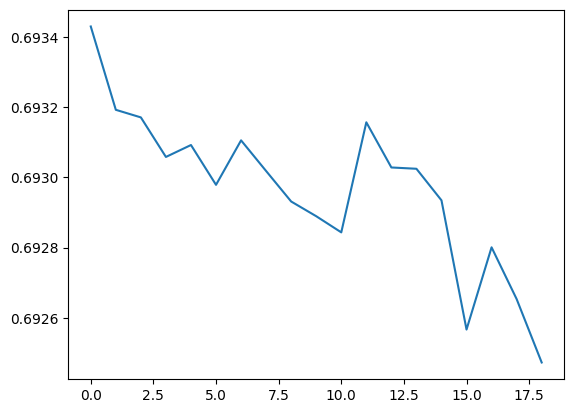

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


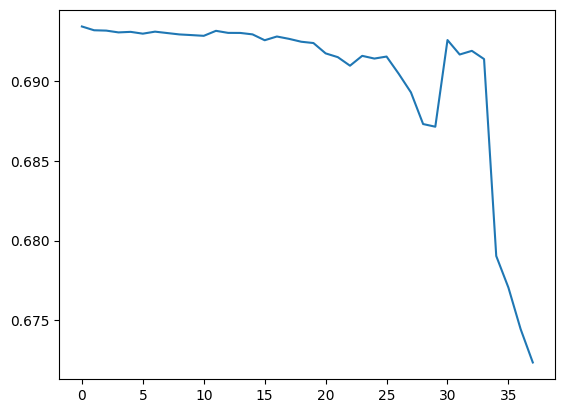

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


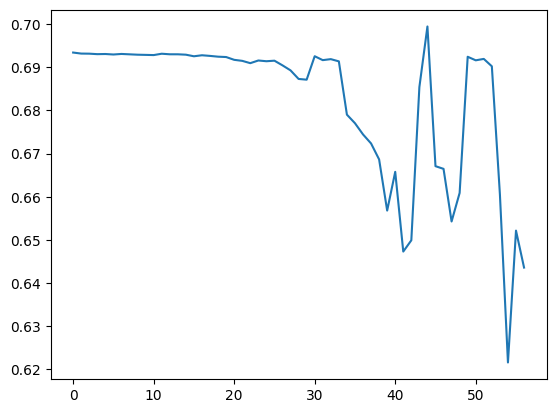

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


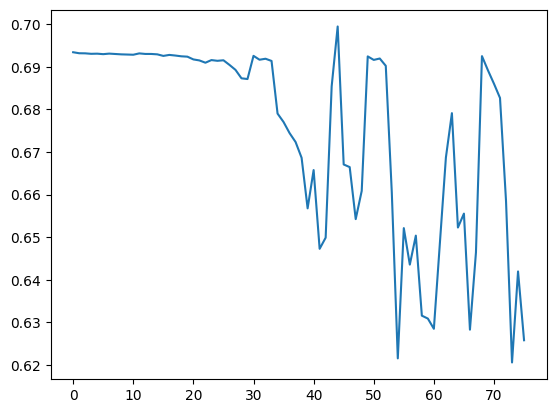

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


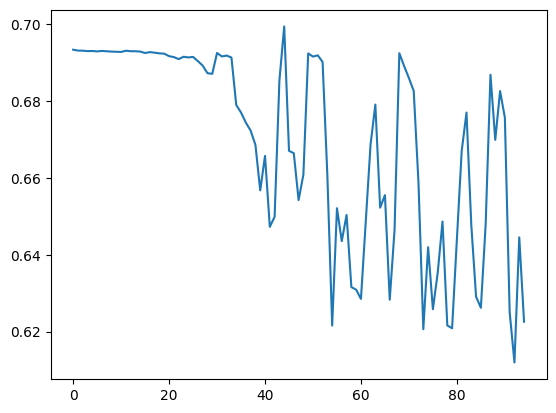

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


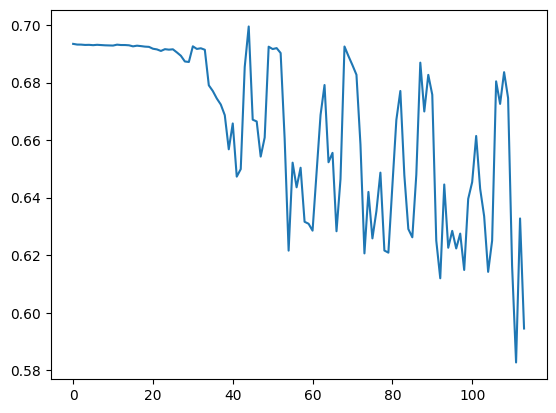

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


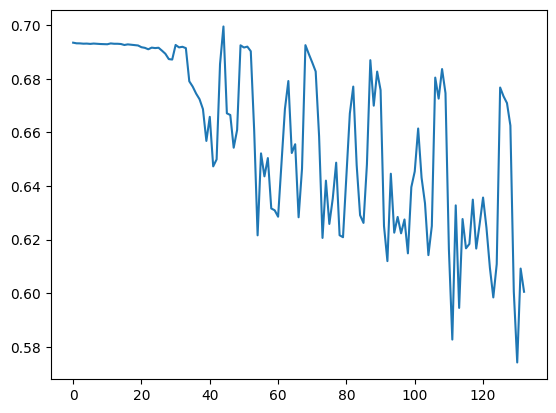

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


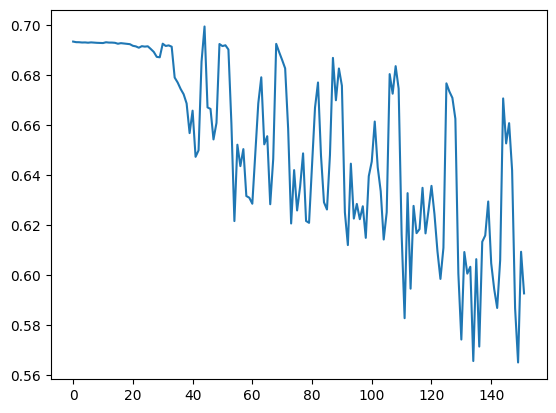

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


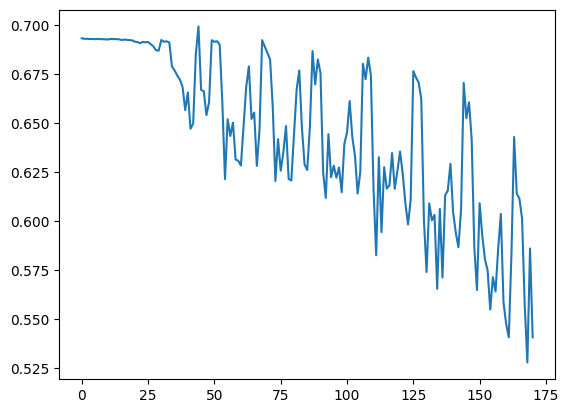

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


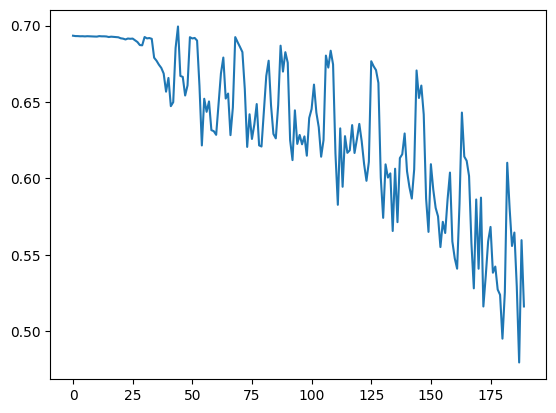

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


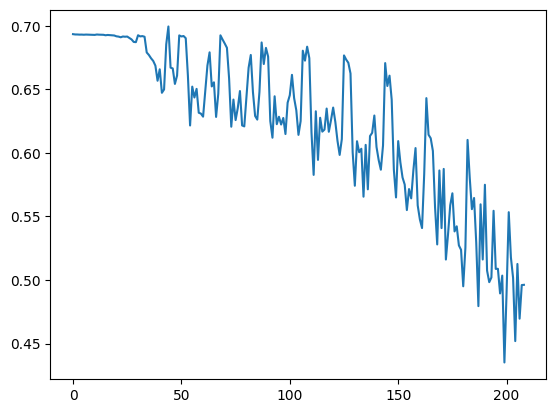

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


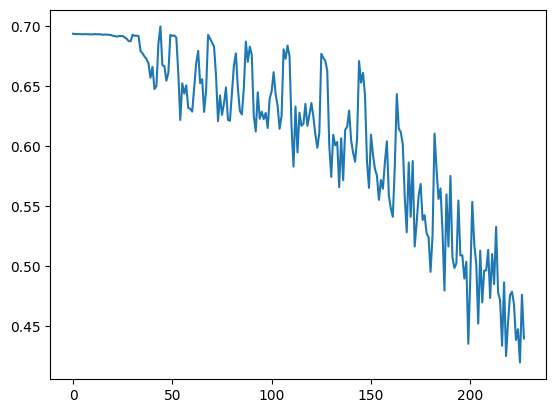

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


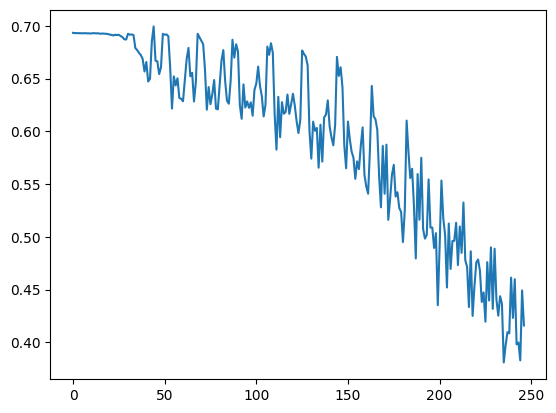

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


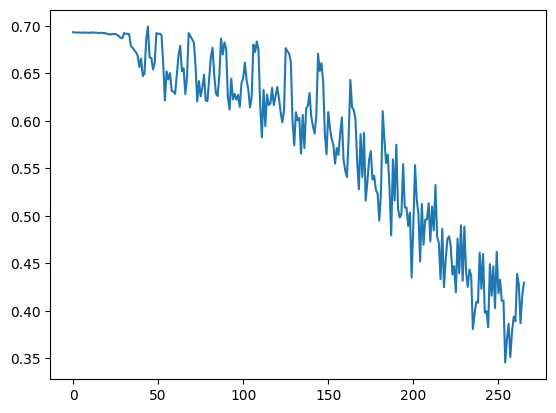

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


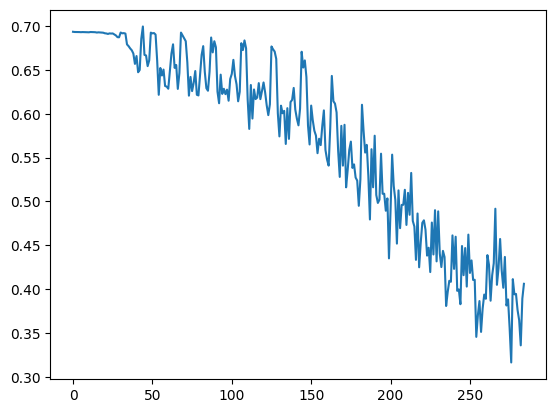

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


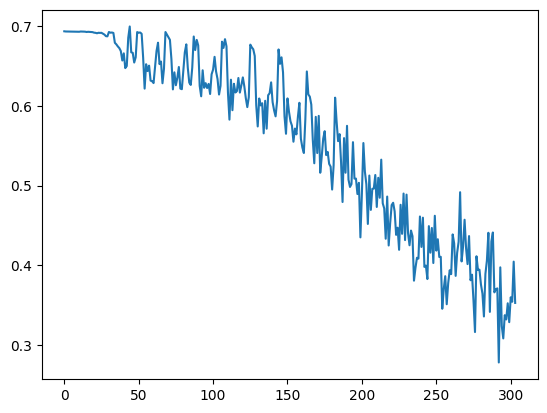

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


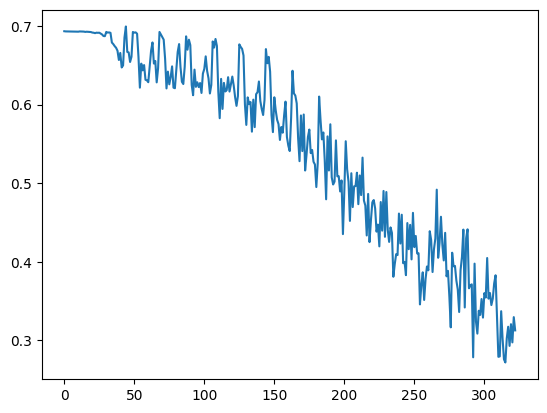

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


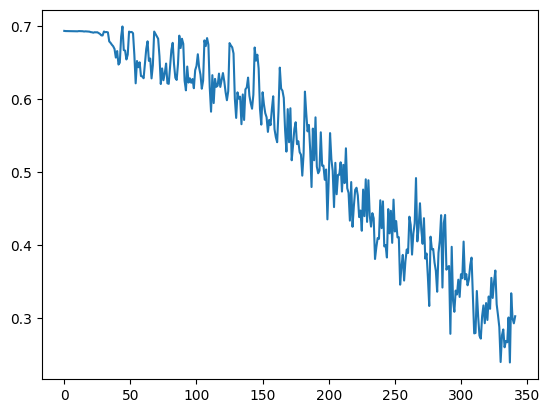

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


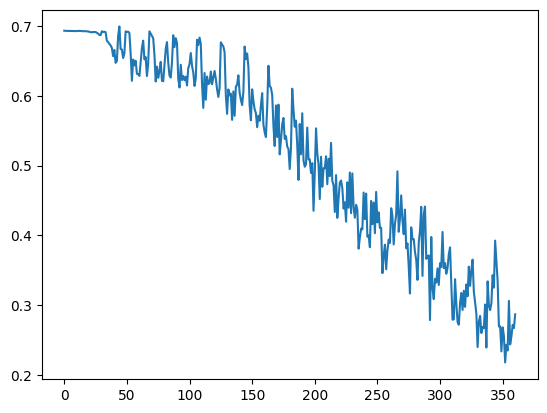

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


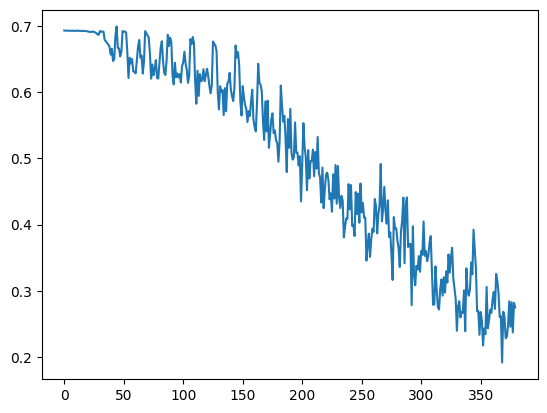

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


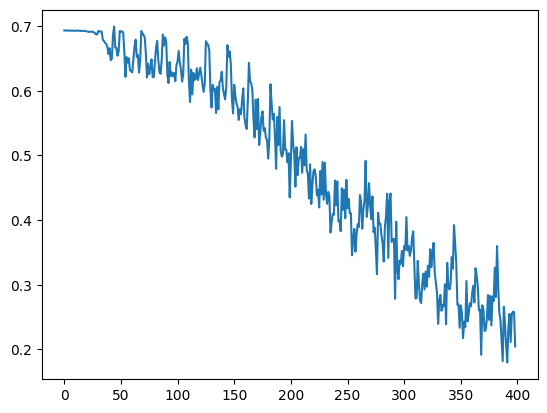

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


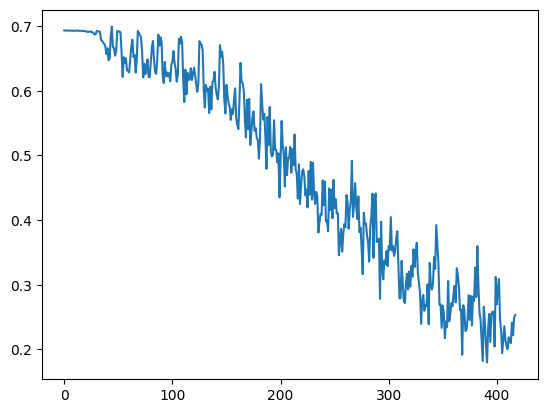

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


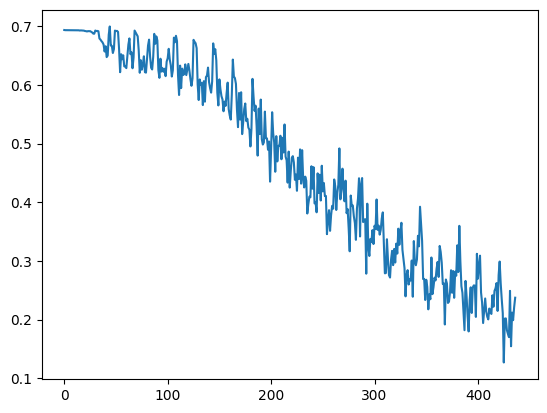

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


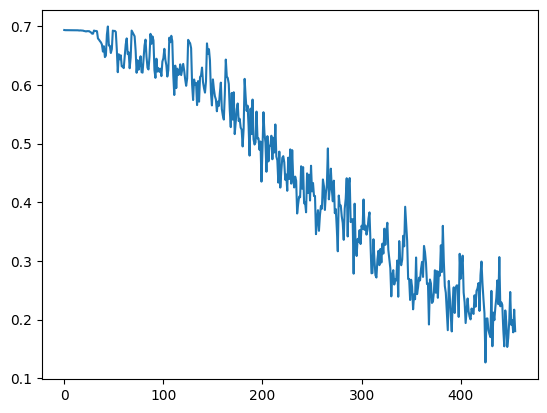

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


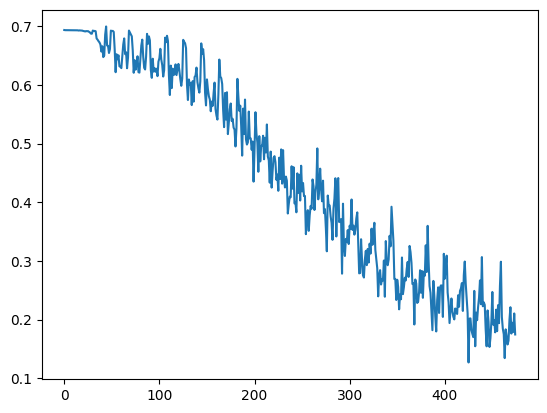

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


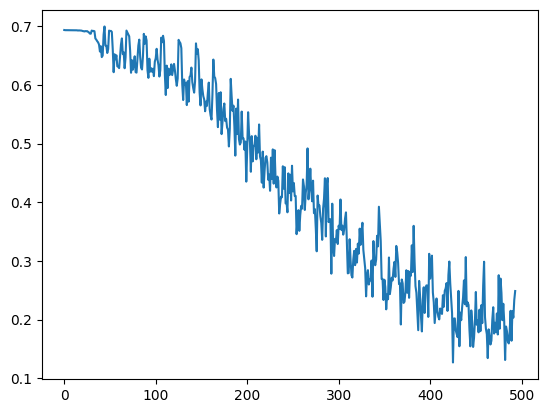

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


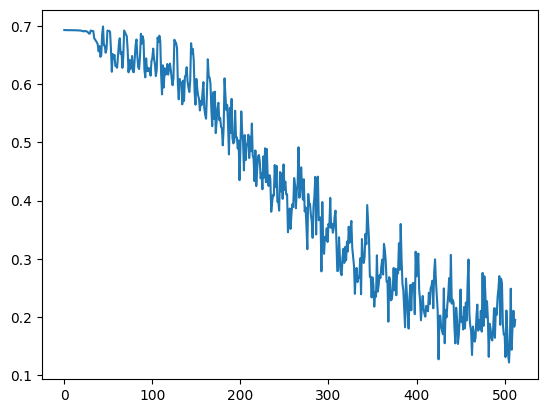

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


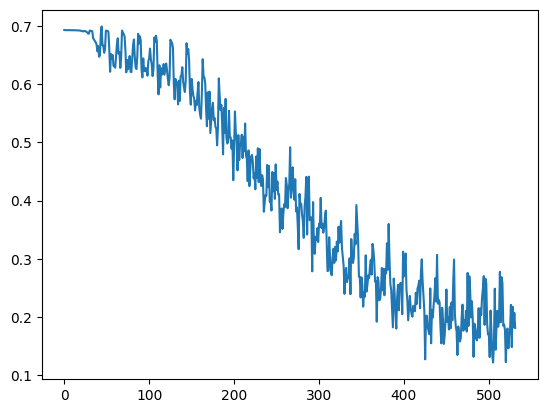

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


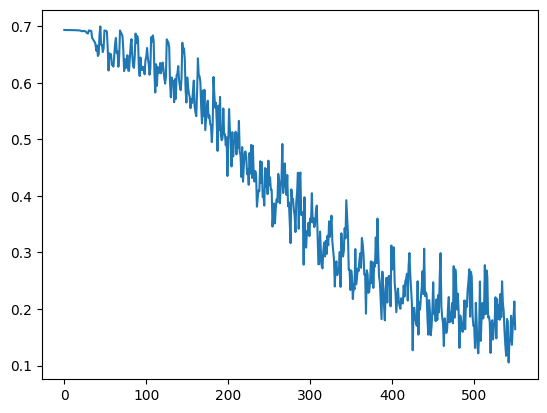

  0%|          | 0/19 [00:00<?, ?it/s]

saved model.


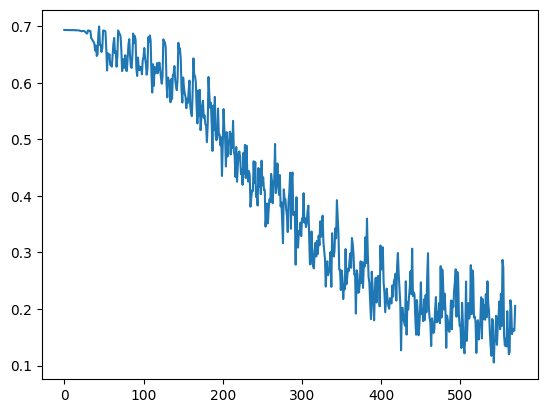

In [44]:
@tf.function
def _train_step(t1,edge_labels):

    
    with tf.GradientTape() as tape:
        res = nw(t1)
        loss= eval_loss(edge_labels, res)
        # loss, grads = _train_step(t1,edge_labels)
        grads = tape.gradient(loss, nw.weights)

    return loss, grads

num_drugs = 1200
for epoch in range(EPOCHS):
    for batch_start in tqdm(range(0, num_drugs, BATCH_SIZE)):
        some_drugs = np.arange(batch_start, batch_start  + BATCH_SIZE)
        drug_links, target_links = sample_neighborhood_of_drugs(some_drugs, prevent_backlink = False)
        t1, edge_labels = _graph_tuple_from_drug_subgraph(drug_links, target_links)
        loss, grads = _train_step(t1, edge_labels)
        opt.apply_gradients(zip(grads, nw.weights))
        losses.append(loss.numpy())
    ckpt.checkpoint_model(epoch)

    pplot.plot(losses)
    pplot.show()

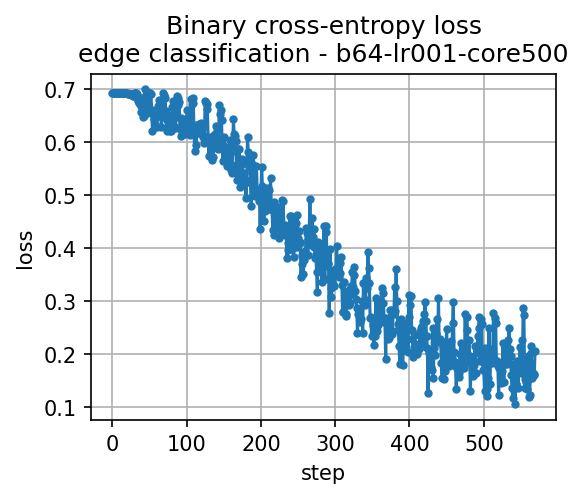

In [49]:
# tf.random.set_seed(123)
pplot.figure(figsize = (4,3), dpi = 150)
pplot.plot(losses,'.-')
pplot.title('Binary cross-entropy loss\nedge classification')
pplot.xlabel('step')
pplot.ylabel('loss')
pplot.grid()

In [45]:
# There is a memory leakage probably due to the tracing of ops in the sampler.
# 1. make a full numpy graph sampler to temporarily remedy that
# 2. make a full tensorflow graph sampler (that can also be traced) for high performance.
# tf.random.set_seed(2134)

In [ ]:
print('Filtered data: %i from %i drug-target data.\nFull drugbank: %i'%(len(filtered_targets), len(targets), len(dbdata)))

Filtered data: 1285 from 4459 drug-target data.
Full drugbank: 15235


In [ ]:
drugs_list = list(df_drug_gene['#Drug'].unique())

In [ ]:
edge_list = df_drug_gene.values
conns_ij = {}
conns_ji = {}

for e1,e2 in edge_list:
    if e1 not in conns_ij:
        conns_ij[e1] = [e2]
    else:
        conns_ij[e1].append(e2)
    if e2 not in conns_ji:
        conns_ji[e2] = [e1]
    else:
        conns_ji[e2].append(e1)

def _dfs_from_drugs(node, depth = 4):
    """
    returns the edge list for a sub-graph centered at a particular node using BFS.
    """
    which_conns = [conns_ij, conns_ji] # swap while traversing
    entity_types = ['drug','gene']
    edge_list_new = [];
    visited = {node : 0}
    entity_list = [node]
    idx_entities = 1
    nodes_list = [node]
    senders = []
    receivers = []
    ent_types = ['drug']
    for it in range(depth):
        next_nodes = []
        for n in nodes_list:
            idx_sender = visited[n]
            inter_nodes = which_conns[it%2][n]
            curr_ent_type = entity_types[(it+1)%2]
            edge_list_new.append([n, inter_nodes])
            for nn in inter_nodes:
                if nn not in visited:
                    next_nodes.append(nn)
                    visited[nn] = idx_entities
                    entity_list.append(nn)
                    ent_types.append(curr_ent_type)

                    senders.append(idx_sender)
                    receivers.append(idx_entities)
                    idx_entities += 1

        nodes_list = next_nodes
    return senders, receivers, entity_list, ent_types

In [ ]:
import numpy as np
RAND_SEED = 42
EMB_SIZE = 64 #@param
np.random.seed(RAND_SEED)
unique_drugs = df_drug_gene['#Drug'].unique()
unique_genes = df_drug_gene['Gene'].unique()
genes_dict, drugs_dict = {k : i for i,k in enumerate(unique_genes)}, {k : i for i,k in enumerate(unique_drugs)}
drug_emb = np.random.randn(len(unique_drugs),EMB_SIZE).astype('float32')/np.sqrt(EMB_SIZE)
gene_emb = np.random.randn(len(unique_genes),EMB_SIZE).astype('float32')/np.sqrt(EMB_SIZE)

def _id_to_emb(_id, _type):
    if _type =='drug':
        return drug_emb[drugs_dict[_id]]
    
    if _type == 'gene':
        return gene_emb[genes_dict[_id]]

In [ ]:
!pip install tf_gnns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tf_gnns import GraphTuple
# help(GraphTuple)#(nodes, edges)

In [ ]:
import tensorflow as tf

edge_emb_size = EMB_SIZE

# Receivers and senders are flipped! (we want to "regress" the emb. of the start node)
def sample_from_node_neighborhood(start_nodes = None, depth = 3):
    if start_nodes is None:
        start_nodes = drugs_list[int(np.random.randint(0,len(drugs_list)-1))]
    senders, receivers, entity_list, ent_types = _dfs_from_drugs(start_nodes, depth = depth)
    edges = np.ones([len(senders),edge_emb_size])*0.01
    
    # flipping senders and receivers:
    # senders, receivers = receivers, senders

    nodes = np.vstack([_id_to_emb(el, et) for el, et in zip(entity_list, ent_types)])
    nodes_in = nodes.copy()
    nodes_in[:,0] = 0
    gt_out = GraphTuple(tf.Variable(nodes),
                    tf.Variable(edges), 
                    senders, receivers,
                    n_nodes = [len(entity_list)], 
                    n_edges = [len(receivers)])
    
    gt_in = GraphTuple(tf.Variable(nodes_in),
                tf.Variable(edges), 
                senders, receivers,
                n_nodes = [len(entity_list)], 
                n_edges = [len(receivers)])
    return  gt_in , gt_out


In [ ]:
from tf_gnns import GraphTuple, GraphNetMLP
gn1 = GraphNetMLP(units = 64, core_steps = 2)

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.0001)

In [ ]:
gt_in, gt_out = sample_from_node_neighborhood()
td_in = gt_in.to_tensor_dict()
del td_in['global_attr']
g2= gn1(td_in)
# gn1.trainable_weights

In [ ]:
losses = []

In [ ]:
from tqdm import tqdm
def eval_loss(n1, n2):
    return tf.reduce_sum(tf.square(n1 - n2))


for i in tqdm(range(10000)):
    with tf.GradientTape() as tape:
        gt_in, gt_out = sample_from_node_neighborhood()
        # gt['nodes'][0,:] = -1. # denoting "hidden"
        td_in = gt_in.to_tensor_dict()
        del td_in['global_attr']
        g2= gn1(td_in)
        loss = eval_loss(gt_out.nodes, g2['nodes'])    
        grads = tape.gradient(loss, gn1.trainable_weights)
        opt.apply_gradients(zip(grads, gn1.trainable_weights))
        losses.append(loss.numpy())
        if i % 50 == 0:
            pplot.plot(losses)
            pplot.show()
            pplot.pause(0.1)

In [ ]:
target_ids

,ID,Name,Gene Name,GenBank Protein ID,GenBank Gene ID,UniProt ID,Uniprot Title,PDB ID,GeneCard ID,GenAtlas ID,HGNC ID,Species,Drug IDs
0,1,Peptidoglycan synthase FtsI,ftsI,1574687.0,L42023,P45059,FTSI_HAEIN,NaN,NaN,NaN,NaN,Haemophilus influenzae (strain ATCC 51907 / DS...,DB00303
1,2,Histidine decarboxylase,HDC,32109.0,X54297,P19113,DCHS_HUMAN,4E1O,NaN,HDC,HGNC:4855,Humans,DB00114; DB00117
2,3,"Glutaminase liver isoform, mitochondrial",GLS2,6650606.0,AF110330,Q9UI32,GLSL_HUMAN,4BQM,NaN,GLS2,HGNC:29570,Humans,DB00142
3,4,Coagulation factor XIII A chain,F13A1,182309.0,M22001,P00488,F13A_HUMAN,1EVU; 1EX0; 1F13; 1FIE; 1GGT; 1GGU; 1GGY; 1QRK...,NaN,F13A1,HGNC:3531,Humans,DB02340; DB11300; DB11311; DB11571; DB13151
4,5,"Nitric oxide synthase, inducible",NOS2,292242.0,L09210,P35228,NOS2_HUMAN,1NSI; 2LL6; 2NSI; 3E7G; 3EJ8; 3HR4; 4CX7; 4NOS,NaN,NOS2A,HGNC:7873,Humans,DB00125; DB00155; DB00244; DB01017; DB01110; D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,3458,T-cell surface glycoprotein CD3 zeta chain,CD247,NaN,BC025703,P20963,CD3Z_HUMAN,1TCE; 1YGR; 2HAC; 2OQ1; 3IK5; 3IOZ; 4XZ1,NaN,CD247,HGNC:1677,Humans,DB16655; DB16684
5342,11222,Plasmepsin X,PMX,NaN,NaN,Q8IAS0,PLM10_PLAF7,7RY7,NaN,NaN,NaN,Plasmodium falciparum (isolate 3D7),DB17096
5343,11227,Plasmepsin X,PMX,NaN,NaN,W7JWW5,PLM10_PLAFO,NaN,NaN,NaN,NaN,Plasmodium falciparum (isolate NF54),DB17096
5344,11231,Fusion glycoprotein F0,F,NaN,NaN,P03420,FUS_HRSVA,2MDP; 3IXT; 3KPE; 3O41; 3O45; 3RKI; 3RRR; 3RRT...,NaN,NaN,NaN,Human respiratory syncytial virus A (strain A2),DB16258


## Resources:
* TO CHECK: Predictive Toxicogenomics space : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5500850/
* AstraZeneca video:https://www.youtube.com/watch?v=qH3z5GwccxE

In [ ]:
!wget http://current.geneontology.org/ontology/subsets/goslim_chembl.json

--2023-03-26 10:14:58--  http://current.geneontology.org/ontology/subsets/goslim_chembl.json
Resolving current.geneontology.org (current.geneontology.org)... 99.84.238.200, 99.84.238.164, 99.84.238.199, ...
Connecting to current.geneontology.org (current.geneontology.org)|99.84.238.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585494 (572K) [application/json]
Saving to: ‘goslim_chembl.json’

goslim_chembl.json  100%[===================>] 571.77K   988KB/s    in 0.6s    

2023-03-26 10:15:00 (988 KB/s) - ‘goslim_chembl.json’ saved [585494/585494]



In [ ]:
import json 
chembl = json.load(open('goslim_chembl.json','r'))

In [ ]:
triplets = []
for n in chembl['graphs'][0]['edges']:
    break

{'sub': 'http://purl.obolibrary.org/obo/GO_0043065', 'pred': 'http://purl.obolibrary.org/obo/RO_0002211', 'obj': 'http://purl.obolibrary.org/obo/GO_0012501'}


In [ ]:
chembl['graphs'][0]['nodes'][0]

{'id': 'http://purl.obolibrary.org/obo/GO_0016192',
 'meta': {'definition': {'val': 'A cellular transport process in which transported substances are moved in membrane-bounded vesicles; transported substances are enclosed in the vesicle lumen or located in the vesicle membrane. The process begins with a step that directs a substance to the forming vesicle, and includes vesicle budding and coating. Vesicles are then targeted to, and fuse with, an acceptor membrane.',
   'xrefs': ['GOC:ai', 'GOC:mah', 'ISBN:08789310662000']},
  'subsets': ['http://purl.obolibrary.org/obo/go#goslim_pir',
   'http://purl.obolibrary.org/obo/go#goslim_chembl',
   'http://purl.obolibrary.org/obo/go#goslim_generic',
   'http://purl.obolibrary.org/obo/go#goslim_drosophila',
   'http://purl.obolibrary.org/obo/go#goslim_candida',
   'http://purl.obolibrary.org/obo/go#goslim_pombe'],
  'synonyms': [{'pred': 'hasExactSynonym',
    'val': 'vesicular transport',
    'xrefs': ['GOC:mah']},
   {'pred': 'hasRelatedSynon